# Road Damage Detection Using Faster RNN & ViT

## 1. Import Libraries

In [2]:
import os
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, utils
from torchvision.transforms import *
from PIL import Image

import pathlib
import xml.etree.ElementTree as ET

np.random.seed(37)
torch.manual_seed(37)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


## 2. Prepareation of Dataset and Notebook

### The dataset is from Crowdsensing-based Road Damage Detection Challenge (CRDDC2022) (https://crddc2022.sekilab.global)

For more information about the dataset, please visit:
https://github.com/sekilab/RoadDamageDetector

Only the data for Japan is trained in this notebook as the data contain more class than others.

### The notebook take credit from:
1. One-Off Coder: https://learn-pytorch.oneoffcoder.com/object-detection.html
2. Pytorch Vision: https://pytorch.org/vision/main/models/faster_rcnn.html

### There are 7 classes of road damages in the database:


| **Class Code** | **Damage Type **                     |
| ----- | ----- |
| **0. D00** | Longitudinal Crack                       |
| **1. D10** | Transverse Crack                         |
| **2. D20** | Aligator Crack                           |
| **3. D40** | Pothole                                  | 
| **4. D43** | Cross Walk Blur                          |
| **5. D44** | White Line Blur                          |
| **6. D50** | Manhole Cover (TBC)                      |

<img src=https://miro.medium.com/v2/resize:fit:796/format:webp/1*pbG5wxeJ7QAp9KskbvfTSA.png width=700/>
researchgate.net (typo in the table, i.e. D43 shall be "Cross Walk Blur" and D44 shall be "White Line Blur")

In [4]:
# Get the list for the data without labels
def remove_data(root_dir, annot_dir='annotations', image_dir='images'):
    full_list = [f for f in sorted(pathlib.Path(root_dir + "/" + annot_dir).glob('**/*.xml'))]
    __trim_xml_list = []
    __trim_image_list = []
    
    for __list in full_list:
        tree = ET.parse(__list)
        root = tree.getroot()

        if not root.findall('./object'):
            __trim_xml_list.append(__list)
            __trim_image_list.append(f"{root_dir}/{image_dir}/{root.find('filename').text}")
        
    return __trim_xml_list, __trim_image_list

In [5]:
# Remove inconsistent images and labels

# trim_xml_list, trim_image_list = remove_data(root_dir = "./Japan")
# len(trim_xml_list), len(trim_image_list)

# for f in trim_xml_list:
#    os.remove(f)

# for f in trim_image_list:
#    os.remove(f)

In [6]:
# Get the list of data where ymax < ymin and/or xmax < xmin
def remove_data_bbox(root_dir, annot_dir='annotations', image_dir='images'):
    full_list = [f for f in sorted(pathlib.Path(root_dir + "/" + annot_dir).glob('**/*.xml'))]
    __trim_xml_bbox_list = []
    
    for __list in full_list:
        tree = ET.parse(__list)
        root = tree.getroot()
        
        for obj in root.findall('./object'):
            o = {}
            o['name'] = obj.find('name').text
            b = obj.find('bndbox')
            o['xmin'] = int(b.find('xmin').text)
            o['ymin'] = int(b.find('ymin').text)
            o['xmax'] = int(b.find('xmax').text)
            o['ymax'] = int(b.find('ymax').text)

            if (o['xmin'] == 264 and o['xmax'] == 264):
                __trim_xml_bbox_list.append(__list)
        
    return __trim_xml_bbox_list

In [7]:
# trim_xml_bbox_list = remove_data_bbox(root_dir="./Japan")
# trim_xml_bbox_list = list(set(trim_xml_bbox_list))
# len(trim_xml_bbox_list), len(dataset)

In [8]:
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def collate_fn(batch):
    return tuple(zip(*batch))

class RDD_Dataset(Dataset):

    def __init__(self, root_dir, annot_dir='annotations', image_dir='images',
                 transform=transforms.Compose([ToTensor()])):
        self.annot_dir = f'{root_dir}/{annot_dir}'
        self.image_dir = f'{root_dir}/{image_dir}'
        self.transform = transform
        self.__init()

    def num_classes(self):
        return len(self.class2index)

    def __get_annot_files(self):
        def clean_up(path):
            import os
            from shutil import rmtree

            ipynb_checkpoints = f'{path}/.ipynb_checkpoints'
            if os.path.exists(ipynb_checkpoints):
                rmtree(ipynb_checkpoints)
        clean_up(self.annot_dir)
        return [f for f in sorted(pathlib.Path(self.annot_dir).glob('**/*.xml'))]

    def __get_classes(self):
        xml_files = self.__get_annot_files()
        names = set()
        for xml_file in xml_files:
            tree = ET.parse(xml_file)
            root = tree.getroot()

            for item in root.findall('./object'):
                name = item.find('name').text
                if name not in names:
                    names.add(name)
        names = {name: i for i, name in enumerate(sorted(list(names)))}
        return names

    def __get_image_annotations(self, annot_path):
        root = ET.parse(annot_path).getroot()
        d = {}

        # file names
        d['annot_path'] = annot_path
        d['image_path'] = f"{self.image_dir}/{root.find('filename').text}"

        # size
        size = root.find('./size')
        d['size'] = {
                'width': int(size.find('width').text),
                'height': int(size.find('height').text),
                'depth': 3  # int(size.find('depth').text
            }

        # objects
        d['objects'] = []
        for obj in root.findall('./object'):
            o = {}
            o['name'] = obj.find('name').text

            b = obj.find('bndbox')
            o['xmin'] = int(b.find('xmin').text)
            o['ymin'] = int(b.find('ymin').text)
            o['xmax'] = int(b.find('xmax').text)
            o['ymax'] = int(b.find('ymax').text)

            d['objects'].append(o)
        return d

    def __init(self):
        self.class2index = self.__get_classes()

        annot_paths = [f'{str(f)}' for f in self.__get_annot_files()]
        self.annotations = [self.__get_image_annotations(p) for p in annot_paths]

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        def get_boxes(annot):
            boxes = [[obj[f] for f in ['xmin', 'ymin', 'xmax', 'ymax']] for obj in annot['objects']]
            return torch.as_tensor(boxes, dtype=torch.float)

        def get_labels(annot):
            labels = [self.class2index[obj['name']] for obj in annot['objects']]
            return torch.as_tensor(labels, dtype=torch.int64)

        def get_areas(annot):
            areas = [(obj['xmax'] - obj['xmin']) * (obj['ymax'] - obj['ymin']) for obj in annot['objects']]
            return torch.as_tensor(areas, dtype=torch.int64)

        def get_iscrowds(annot):
            return torch.zeros((len(annot['objects']),), dtype=torch.uint8)

        annot = self.annotations[idx]

        image_path = annot['image_path']
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)

        target = {}
        target['boxes'] = get_boxes(annot)
        target['labels'] = get_labels(annot)
        target['image_id'] = torch.as_tensor([idx], dtype=torch.int64)
        target['area'] = get_areas(annot)
        target['iscrowd'] = get_iscrowds(annot)

        return image, target

dataset = RDD_Dataset(root_dir="./Japan")
indices = torch.randperm(len(dataset)).tolist() #returns a row vector containing a random permutation of the integers from 1 to n without repeating elements.

dataset_train = Subset(dataset, [i for i in range(8000)])
dataset_test = Subset(dataset, [i for i in range(8000,9700,1)])

dataloader_train = DataLoader(
    dataset_train, batch_size=4, shuffle=True, num_workers=0, collate_fn=collate_fn)
dataloader_test = DataLoader(
    dataset_test, batch_size=4, shuffle=True, num_workers=0, collate_fn=collate_fn)

In [9]:
len(dataset_train), len(dataset_test)

(8000, 1700)

## 2. Baseline Model

In [10]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_V2_Weights

device = get_device()

model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT)
num_classes = dataset.num_classes()
in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model = model.to(device)

In [11]:
in_features

1024

## 3. Optimizer and Scheduler

In [12]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

## 4. Helper Code

In [13]:
%%sh
if [ ! -d "output/vision" ]; then
    git clone https://github.com/pytorch/vision.git output/vision
else
    echo "output/vision already cloned"
fi

cp output/vision/references/detection/utils.py .
cp output/vision/references/detection/transforms.py .
cp output/vision/references/detection/coco_eval.py .
cp output/vision/references/detection/engine.py .
cp output/vision/references/detection/coco_utils.py .

output/vision already cloned


## 5. Training and Testing

In [18]:
from engine import train_one_epoch, evaluate
import utils

num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, dataloader_train, device, epoch , print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, dataloader_test, device=device)

print("That's it!")

Epoch: [0]  [   0/2000]  eta: 14:24:46  lr: 0.000010  loss: 0.3521 (0.3521)  loss_classifier: 0.0912 (0.0912)  loss_box_reg: 0.2042 (0.2042)  loss_objectness: 0.0331 (0.0331)  loss_rpn_box_reg: 0.0236 (0.0236)  time: 25.9433  data: 0.0255
Epoch: [0]  [ 100/2000]  eta: 11:03:18  lr: 0.000509  loss: 0.2725 (0.2788)  loss_classifier: 0.0967 (0.1034)  loss_box_reg: 0.1252 (0.1323)  loss_objectness: 0.0196 (0.0240)  loss_rpn_box_reg: 0.0130 (0.0191)  time: 15.7098  data: 0.0244
Epoch: [0]  [ 200/2000]  eta: 11:05:01  lr: 0.001009  loss: 0.2350 (0.2670)  loss_classifier: 0.0897 (0.1010)  loss_box_reg: 0.1036 (0.1261)  loss_objectness: 0.0151 (0.0227)  loss_rpn_box_reg: 0.0129 (0.0171)  time: 23.4792  data: 0.0384
Epoch: [0]  [ 300/2000]  eta: 10:17:29  lr: 0.001508  loss: 0.2746 (0.2665)  loss_classifier: 0.1095 (0.1017)  loss_box_reg: 0.1254 (0.1264)  loss_objectness: 0.0175 (0.0219)  loss_rpn_box_reg: 0.0140 (0.0166)  time: 22.6544  data: 0.0321
Epoch: [0]  [ 400/2000]  eta: 9:35:23  lr: 0

[W ParallelNative.cpp:230] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)


creating index...
index created!
Test:  [  0/425]  eta: 1:04:10  model_time: 9.0127 (9.0127)  evaluator_time: 0.0183 (0.0183)  time: 9.0589  data: 0.0278
Test:  [100/425]  eta: 0:39:06  model_time: 7.1021 (7.1836)  evaluator_time: 0.0037 (0.0051)  time: 7.1670  data: 0.0303
Test:  [200/425]  eta: 0:27:02  model_time: 7.1882 (7.1750)  evaluator_time: 0.0037 (0.0047)  time: 7.2108  data: 0.0350
Test:  [300/425]  eta: 0:15:04  model_time: 7.2382 (7.2014)  evaluator_time: 0.0038 (0.0054)  time: 7.5768  data: 0.0301
Test:  [400/425]  eta: 0:02:54  model_time: 5.9053 (6.9395)  evaluator_time: 0.0044 (0.0052)  time: 6.5264  data: 0.0249
Test:  [424/425]  eta: 0:00:07  model_time: 7.7202 (6.9969)  evaluator_time: 0.0048 (0.0053)  time: 8.1427  data: 0.0327
Test: Total time: 0:49:48 (7.0326 s / it)
Averaged stats: model_time: 7.7202 (6.9969)  evaluator_time: 0.0048 (0.0053)
Accumulating evaluation results...
DONE (t=0.50s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   al

# Total two epochs trained on full data to obtained the above results

# 6. Predictions

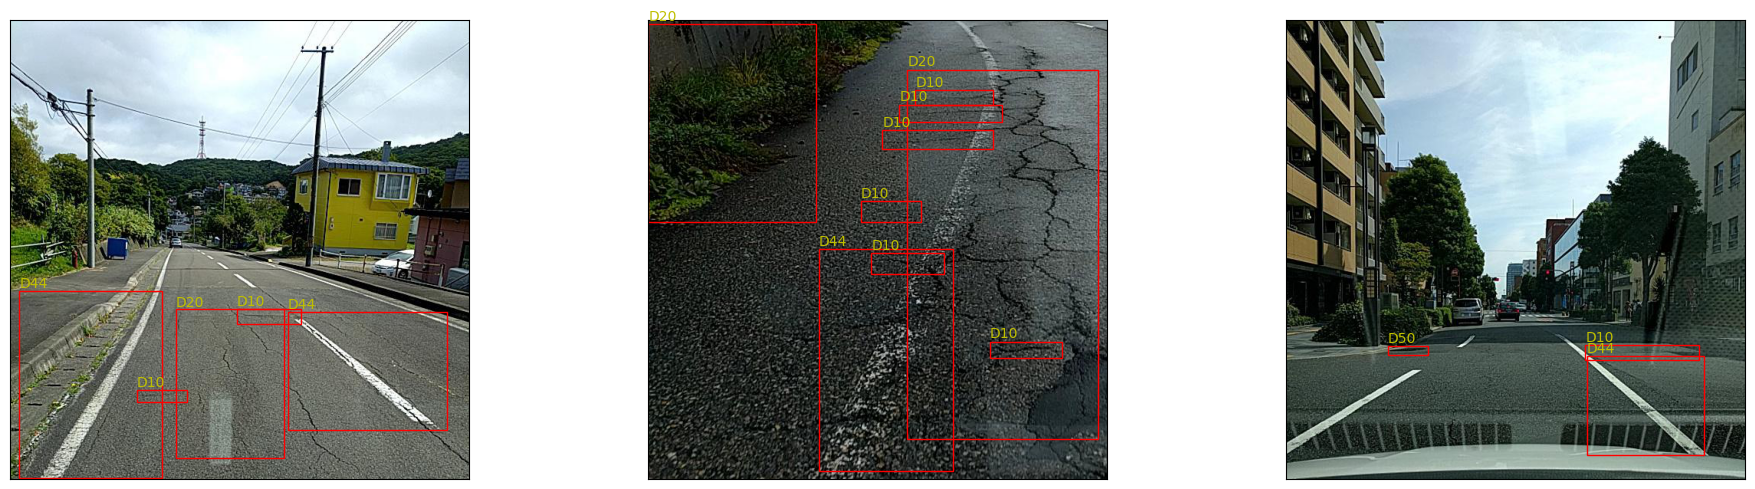

In [19]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.patches as patches


# function apply_nms performs non-maximum suppression (NMS) on the boxes according to their intersection-over-union (IoU).
# Set lower iou threshold if to many bounding boxes
IOU_THRESH=0.1

def apply_nms(orig_prediction, iou_thresh=IOU_THRESH):
    
    orig_prediction = orig_prediction[0]
    # torchvision returns the indices of the bounding boxes and theirs attributes 
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return [final_prediction]

def get_prediction(dataset, idx, model):
    img, _ = dataset[idx]

    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])
        
    prediction = apply_nms(prediction, iou_thresh=IOU_THRESH)

    return img, prediction

def get_rects(boxes):
    rect = lambda x, y, w, h: patches.Rectangle((x, y), w - x, h - y, linewidth=1, edgecolor='r', facecolor='none')

    return [rect(box[0], box[1], box[2], box[3]) for box in boxes]

def get_clazzes(labels, boxes, index2class):
    return [{'x': box[0].item(), 'y': box[1].item() - 5.0, 's': index2class[label.item()], 'fontsize': 10}
            for label, box in zip(labels, boxes)]

def show_prediction(img, index2class, fig, ax):
    pil_image = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

    ax.imshow(pil_image)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

    for rect in get_rects(prediction[0]['boxes']):
        ax.add_patch(rect)


    for label in get_clazzes(prediction[0]['labels'], prediction[0]['boxes'], index2class):
        ax.text(**label, color='y')
    
    
rand_pred = np.random.choice(5000, 3, replace=False)

predictions = [get_prediction(dataset_train, i, model) for i in rand_pred]

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
index2class = {i: c for c, i in dataset.class2index.items()}

for (img, prediction), a in zip(predictions, ax):
    show_prediction(img, index2class, fig, a)

plt.tight_layout()

# 7. Save & Load the Models

In [20]:
from pathlib import Path

# Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True
)

# Create model save path
MODEL_NAME = "RDD_FasterRNN_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/RDD_FasterRNN_0.pth


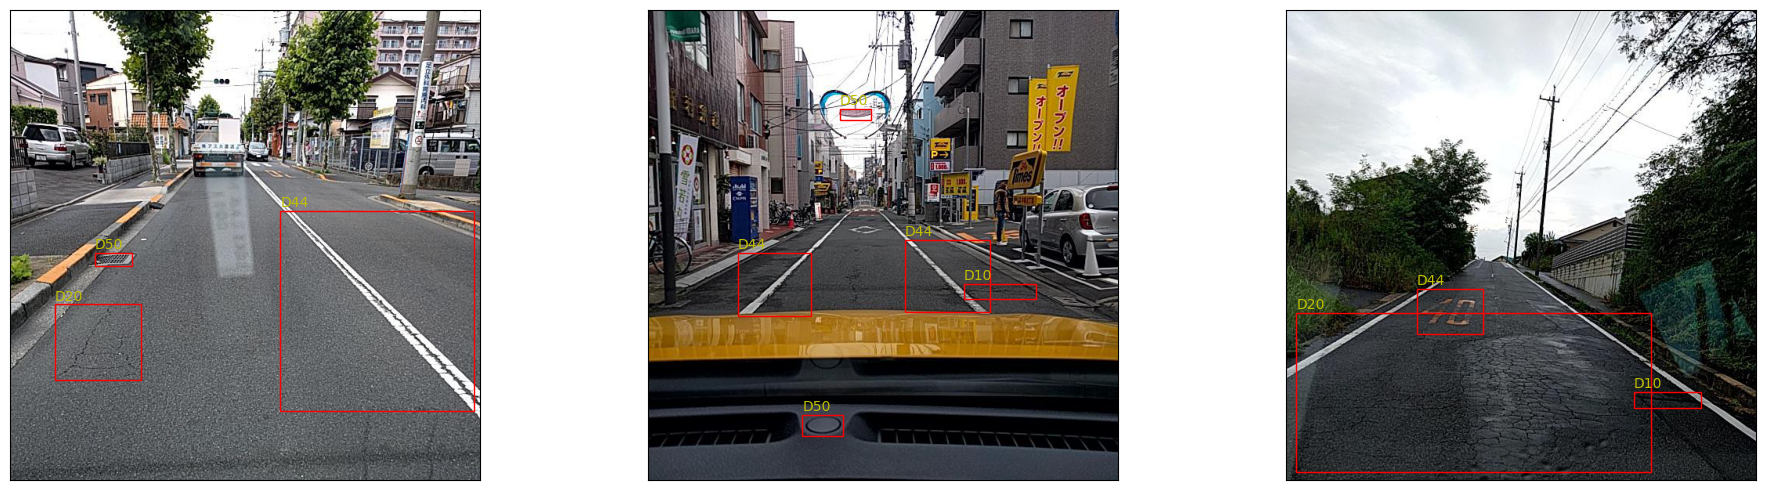

In [21]:
# Load the saved state_dict() to the model
loaded_model = model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Get the prediction
rand_pred = np.random.choice(5000, 3, replace=False)

predictions = [get_prediction(dataset_train, i, model) for i in rand_pred]

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
index2class = {i: c for c, i in dataset.class2index.items()}

for (img, prediction), a in zip(predictions, ax):
    show_prediction(img, index2class, fig, a)

plt.tight_layout()